# NER Model

#### Imports

In [1]:
from gensim.models import KeyedVectors
from nltk.corpus.reader.conll import ConllCorpusReader
import nltk
from nltk import conlltags2tree
from IPython.display import display
import re
from math import floor
import numpy as np
import sys
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from keras.layers.recurrent import LSTM
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Bidirectional, Flatten, Dropout, TimeDistributed
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
import keras.backend as K
from keras_contrib.layers import CRF
from keras_contrib.utils import save_load_utils
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

Using TensorFlow backend.


#### Variables

In [2]:
max_length = 70
num_features = 300

### Feature Extraction

In [3]:
def get_padded_sentence_features(sentences, num_features, max_length, wv):
    features = np.empty((0, max_length, num_features))
    for i in range(len(sentences)):
        if i % 100 == 0:
            print("Processed", i, "of", len(sentences))
        sent = sentences[i]
        new_sent = []
        for j in range(max_length):
            if 0 <= j < len(sent):
                this_word = sent[j]
                if this_word in wv.vocab:
                    new_sent.append(wv.get_vector(this_word))
                elif this_word == '':
                    new_sent.append(np.zeros(num_features))
                else:
                    new_sent.append(np.random.uniform(-0.25,0.25, num_features))  # random vector for unknown
            else:
                new_sent.append(np.zeros(num_features))

        feature_stack = np.dstack([[new_sent]])
        features = np.vstack([features, feature_stack])
        
    return features

### Data Cleaning

In [4]:
nums_regex = re.compile(r'0+')
def clean_sents(sents, max_length):
    cleaned = []
    # remove sentences shorter than 5 words
    for sent in sents:
        if len(sent) > 4 and len(sent) <= max_length:
            new_sent = []
            # clean the words
            for word in sent:
                this_word = word.lower()
                new_word = ''
                # replace numbers with 0
                for char in this_word:
                    if char.isalpha():
                        new_word = new_word + char
                    elif char.isdigit():
                        new_word = new_word + '0'
                new_word = nums_regex.sub('0', new_word)
                new_sent.append(this_word)
            cleaned.append(new_sent)
    return cleaned

Helper function for getting the labels after prediction.

In [5]:
def arr2label(cats, labels):
    new_labels = []
    for i in range(len(cats)):
        sent_labels = []
        for j in range(len(cats[i])):
            label = np.argmax(cats[i][j])
            label = labels[label]
            new_labels.append(label)
    return new_labels


## Load the Data

Load the English word vectors.

In [6]:
wv = KeyedVectors.load_word2vec_format('data/wiki.multi.en.vec.txt', binary=False)

Define class variables for label encoding and decoding.

In [7]:
classes = ['B-MISC', 'I-MISC', 'B-LOC', 'I-LOC', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'O']
num_classes = len(classes)
encoded_classes = range(num_classes)
class2idx = {classes[enc]: enc for enc in encoded_classes}

## Load the Model

Redefine the model before loading it from file.

In [8]:
dropout = 0.1
recurrent_dropout = 0.3
hidden_nodes = 100
window_size = 70

def create_model(num_classes, num_features, hidden_nodes=100):
    model = Sequential()
    model.add(Bidirectional(
        LSTM(units=num_features, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout),
        input_shape=(window_size, num_features,),
        merge_mode='concat'))
    model.add(TimeDistributed(Dense(hidden_nodes, activation='relu')))
    # add a CRF layer to enforce NER IOB rules
    crf = CRF(num_classes, sparse_target=False)
    model.add(crf)
    print("Summary:", model.summary())
    model.compile(optimizer='rmsprop', loss=crf.loss_function, metrics=[crf.accuracy])
    return model

Load the model from file.

In [10]:

model = create_model(num_classes, num_features)
save_load_utils.load_all_weights(model,'models/full_train.h5', include_optimizer=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 70, 600)           1442400   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 70, 100)           60100     
_________________________________________________________________
crf_1 (CRF)                  (None, 70, 9)             1008      
Total params: 1,503,508
Trainable params: 1,503,508
Non-trainable params: 0
_________________________________________________________________
Summary: None


## Test the Model

Run a test sentence.

In [65]:
test_sent = "My name is Tony DiPadova and I study at Dartmouth College" 

In [66]:
test_sent = nltk.word_tokenize(test_sent)  # tokenize the sentence
test = clean_sents([test_sent], max_length)
test_X = get_padded_sentence_features(test, num_features, max_length, wv)  # process the sentence

Processed 0 of 1


In [67]:
pred = model.predict(test_X)  # predict
labels = arr2label(pred, classes)  # get labels
print(test)
print(len(test[0]))
labels = labels[:len(test[0])]  # remove padding

[['my', 'name', 'is', 'tony', 'dipadova', 'and', 'i', 'study', 'at', 'dartmouth', 'college']]
11


In [68]:
tags = [(test_sent[i], labels[i]) for i in range(len(test_sent))]

In [69]:
print(tags)

[('My', 'O'), ('name', 'O'), ('is', 'O'), ('Tony', 'B-PER'), ('DiPadova', 'I-PER'), ('and', 'O'), ('I', 'O'), ('study', 'O'), ('at', 'O'), ('Dartmouth', 'B-ORG'), ('College', 'I-ORG')]


In [70]:
def tag2tree(tags):
    string = '(S'
    for i in range(len(tags)):
        # beginning case
        if i == 0 and tags[i][1] != 'O':
            string += ' (' + tags[i][1][2:] + ' ' + tags[i][0]  # beginning is B-
            if i + 1 < len(tags) and tags[i+1][1] == 'O':
                string += ')'
        elif tags[i][1] == 'O':
            string += ' ' + tags[i][0]
        else:
            # middle cases
            if i < len(tags) - 1:
                if tags[i+1][1] == 'O' and tags[i][1][0] == 'I':
                    string += ' ' + tags[i][0] + ')'
                elif tags[i+1][1][0] == 'I' and tags[i][1][0] == 'I':
                    string += ' ' + tags[i][0] 
                elif tags[i][1][0] == 'B' and tags[i+1][1] == 'O':
                    string += ' (' + tags[i][1][2:] + ' ' + tags[i][0] + ')'
                elif tags[i][1][0] == 'B' and tags[i+1][1][0] == 'I':
                    string += ' (' + tags[i][1][2:] + ' ' + tags[i][0]
            else:
                # end cases
                if tags[i][1][0] == 'B':
                    string += ' (' + tags[i][1][2:] + ' ' + tags[i][0] + ')'
                elif tags[i][1][0] == 'I':
                    string += ' ' + tags[i][0] + ')'
                
    string += ')'
    tree = nltk.Tree.fromstring(string)
    return tree
                
    

(S
  My
  name
  is
  (PER Tony DiPadova)
  and
  I
  study
  at
  (ORG Dartmouth College))


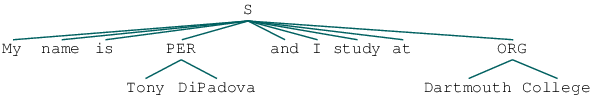

In [71]:
tree = tag2tree(tags)
tree.pprint()
display(tree)